# Motion Planning, Assignment 3: Wavefront Algorithm

#### Thao Dang, Hochschule Esslingen

<a id="fig_1"></a>
![Fig. 1: Robot scenario](https://drive.google.com/uc?export=view&id=1qI_a9NZQa-YHnSuvg-BBn6WED0zXU87g)

In this notebook, you will implement the wavefront algorithm for computing a potential field and finding an optimal path from a start configuration to a given goal. Details on the algorithm can be found in the lecture slides on potential functions.

The assignment will work on a 2D maze grid as depicted in the Figure above. The red square indicates the start position, the green circle the goal. The robot can initially move up/down/left/right (4-point-neighborhood), but you can extend your algorithm to include diagonal movement later.

First, the usual boilerplate code to load the necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap

The following defines a maze including start and goal configurations. Obstacles in the grid are denoted by ``1``, free grid cells by ``0``. You may choose from three difference scenarios (and also add your own, of course).

In [9]:
scenario = 1 # choose your world

if scenario==1:
    world = np.array(
        [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0 ], 
         [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]])
    
elif scenario==2:
    world = np.array(
        [[ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ], 
         [ 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0 ]])
    
elif scenario==3:
    world = np.array(
        [[ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ], 
         [ 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0 ],
         [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0 ]])

else:
    assert False, 'unknown scenario'
    
q_start = (0,0)
q_goal = (14,6)

The following functions may help you in displaying, modifying and accessing a grid:
* ``printWorld`` prints the maze to console
* ``plotWorld`` display the maze, the computed distances, and the start/goal configurations via matplotlib
* ``setWorld``/``getWorld`` are helper functions to access individual grid cells of the maze.

More information is given in the docstrings below.

Initial grid map (1: obstacle, 0: free):

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

q_start: (0, 0) , q_goal: (14, 6)


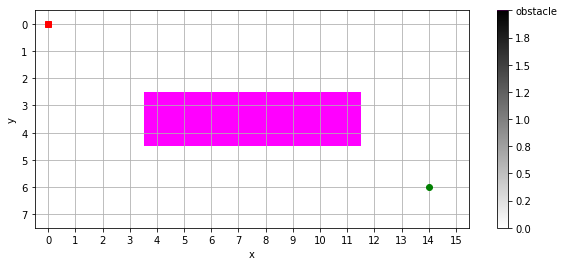

In [10]:
def printWorld(world):
    """Print world map (or distance map) to console."""
    for l in world:
        print(l)
        
def plotWorld(world, start=None, goal=None):
    """Draws world map (or distance map) in matplotlib figure.
    
    Optionally, start and goal configuration are also shown.
    """
    plt.figure(figsize=(10,4))
    y_dim, x_dim = world.shape
    disp_world = world.copy()
    obstacle_val = int( 1 + np.max(disp_world.flatten())*1.2 )
    disp_world[disp_world==1] = obstacle_val
    
    graymap = cm.get_cmap('gray', 256)
    newcolors = graymap(np.linspace(0, 1, 256))
    newcolors = np.flipud(newcolors)
    newcolors[-1,:] = [1, 0, 1, 1]
    newcmap = ListedColormap(newcolors)

    plt.imshow(disp_world, cmap=newcmap)
    plt.gca().set_xticks([x for x in range(x_dim)])
    plt.gca().set_yticks([y for y in range(y_dim)])
    plt.xlabel('x')
    plt.ylabel('y')
    cb = plt.colorbar()
    yticks = cb.ax.get_yticks()
    yticks[-1] = obstacle_val
    yticklabels = ['%.1f' % y for y in yticks]
    yticklabels[-1] = 'obstacle'
    cb.set_ticks(yticks)
    cb.ax.set_yticklabels(yticklabels)
    plt.grid(True)
    
    if start:
        plt.plot(start[0], start[1], 'rs')

    if goal:
        plt.plot(goal[0], goal[1], 'go')
        
def setWorld(world, q, val):
    """Set value at a given configuration q in grid map world.
    
    Note that (as in images), x- and y-coordinates are swapped."""
    world[q[1], q[0]] = val
    
def getWorld(world, q):
    """Get value at a given configuration q from grid map world.
    
    Note that (as in images), x- and y-coordinates are swapped."""
    return world[q[1], q[0]]


# print grid on console
print('Initial grid map (1: obstacle, 0: free):\n')
printWorld(world)
print('\nq_start:', q_start, ', q_goal:', q_goal)


# plot grid via matplotlib 
plotWorld(world, start=q_start, goal=q_goal)

## Exercise 1: Neighborhoods

To simplify processing later, first implement a function ``neighbors`` that returns all valid neighbor points of a configuration ``q``. The neighborhood shall first be given by a 4-point-neighborhood (up/down/left/right), but may later be extended to an 8-point-neighborhood. Note that only valid neighborhood points should be returned, i.e. grid cells that lie **within** the maze but may or may not contain obstacles. 

The return value of this function should be a list of tuples. Also make sure your code passes the test scenarios given below.

In [17]:
def neighbors(world, q):
    """Returns the neighborhood of q in grid map as a list of configurations.
    
    Args:
        world:  grid map with "1" indicating an obstacle, all other values 
                indicate free space (potentially with distance values).
        q:      tuple (x,y) indicating the current configuration

    Returns:
        The neighborhood of q as a list of tuples [(x1, y1), (x2, y2), ...]. 
        Note that only such neighbors are returned that lie within the grid!  
    """
    x, y = q
    y_dim, x_dim = world.shape
    
    tmp = []
    if x-1 >= 0:
        tmp.append((x-1,y))
    if x+1<x_dim:
        tmp.append((x+1,y))
    if y-1>=0:
        tmp.append((x,y-1))
    if y+1<y_dim:
        tmp.append((x,y+1))
    
    ## INSERT CODE HERE
    return tmp      
    ## END INSERTED CODE


# Test with following test cases:

# for 8-point neighborhood:
#assert set(neighbors(world, (5,4))) == set([(4, 3), (5, 3), (6, 3), (4, 4), (6, 4), (4, 5), (5, 5), (6, 5)])
#assert set(neighbors(world, (0,0))) == set([(1, 0), (0, 1), (1, 1)])

# for 4-point neighborhood:
assert set(neighbors(world, (5,4))) == set([(5, 3), (4, 4), (6, 4), (5, 5)])
assert set(neighbors(world, (0,0))) == set([(1, 0), (0, 1)])

## Exercise 2: Distance map

Now compute the distance map as described in the lecture. The function to do this, ``wavefront_distance``, is specified below.

Notes:
* Compute the full distance map, i.e. an "early stopping" when encountering the start configuration is not necessary.
* You may find the list funcions ``list.pop(0)`` (which pops the first element form the list ``list``) and ``list.append(q)`` (which adds ``q`` at the end of list ``list``) useful.

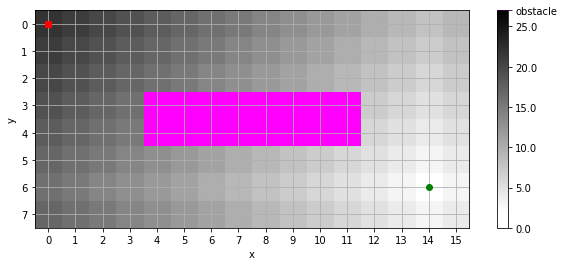

In [18]:
def wavefront_distance(world, q_goal):
    """Compute a distance map using the wavefront algorithm.
    
    Args:
        world:   grid map with "1" indicating an obstacle, "0" indicating free space.
        q_goal:  tuple (x,y) indicating the goal configuration in the world

    Returns:
        A distance map w in grid form:
            * w(x,y)==1 indicates a grid cell occupied by an obstacle
            * w(x,y)==0 indicates a grid cell from which q_goal cannot be reached 
            * w(x,y)>1  indicates the distance of (x,y) from q_goal
    """
    w = world.copy()
    
    ## INSERT CODE HERE
    L= []
    #L.append(q_goal)
    setWorld(w,q_goal,2)
    ps = neighbors(w, q_goal)
    for p in ps:
        val = getWorld(w, p)
        if val == 0:
            L.append(p)
    while len(L)!=0:
        q = L.pop(0)
        ps = neighbors(w, q)
        small = []
        for p in ps:
            val = getWorld(w, p)
            if val == 0:
                L.append(p)
            elif val>1:
                small.append(val)
            if len(small) != 0:
                setWorld(w,q,min(small)+1)
        

    ## END INSERTED CODE

    return w


# compute distance map and display results
dist_map = wavefront_distance(world, q_goal)

plotWorld(dist_map, start=q_start, goal=q_goal)

## Exercise 3: Find a path

Given the distance map from the previous step, now find a shortest path doing a gradient descent starting from ``q_start``: Find the next grid cell that decreases the distance cost by 1, go there and repeat until you reach the goal.

Make sure to check if you can actually reach the goal before starting the search.

Plot the optimal path (if any) using matplotlib's ``plt.plot`` command.

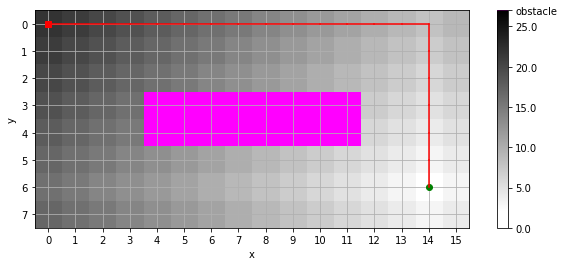

In [30]:
plotWorld(dist_map, start=q_start, goal=q_goal)

## INSERT CODE HERE
q = q_start
currDist = getWorld(dist_map, q)

while q != q_goal:
    for p in neighbors(dist_map, q):
        val = getWorld(dist_map, p)
        if val == currDist-1:
            currDist = val
            plt.plot([q[0], p[0]], [q[1], p[1]], 'r')
            q = p
            break
    



## Optional excercises

* Test the algorithm and create your own scenarios .
* Modify the code so that the robot can move diagonally (8-point-neighborhood).